## Mechanistic hypothesis validation (mechanistic_aniso_moons)

### Narrow hypothesis (operational)
Adversarial/OOD samples are enriched among points whose **metric-conditioned, class-conditional** local geometry is atypical for the predicted class.

This notebook is designed as a **mechanistic** test:
- We generate a *controlled* synthetic dataset where clean neighborhoods have **location-dependent anisotropy** (a nuisance factor).
- We test whether **local metric conditioning (whiten)** + **class-conditional neighborhoods** is necessary to make PH features comparable and improve detection.

Key outputs:
- ROC curves + AUC, FPR@95
- Score distributions
- Successful-only vs all-attacks stratification
- Neighborhood clouds pre/post whitening (qualitative)
- PCA of penultimate features (clean vs adv)
- Score vs classification margin


In [1]:
import pathlib
import sys
import time
from dataclasses import replace

import numpy as np
import matplotlib.pyplot as plt

repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.api import (
    get_dataset,
    get_model,
    train,
    generate_adversarial,
    compute_scores,
    concat_scores,
    fit_detector,
    attack_success_mask,
)
from src.evaluation import evaluate_detector
from src.models import get_model_predictions, get_model_logits, extract_features_batch
from src.utils import ExperimentConfig, DataConfig, ModelConfig, AttackConfig, GraphConfig, DetectorConfig
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


### Config

Notes:
- PH dominates runtime; subsample val/test.
- You can increase `mech_sigma_*` to make anisotropy stronger.


In [2]:
SEED = 42
MAX_POINTS_FOR_SCORING = 300

cfg_base = ExperimentConfig(
    seed=SEED,
    device='cpu',
    data=DataConfig(
        n_samples=2000,
        noise=0.02,
        train_ratio=0.6,
        val_ratio=0.2,
        test_ratio=0.2,
        mech_sigma_tangent=0.25,
        mech_sigma_normal=0.05,
        mech_class_aniso_scale=1.5,
        mech_warp_strength=0.15,
    ),
    model=ModelConfig(
        input_dim=2,
        output_dim=2,
        hidden_dims=[64, 64, 32],
        epochs=30,
        batch_size=128,
        learning_rate=1e-3,
        weight_decay=1e-4,
    ),
    attack=AttackConfig(attack_type='fgsm', epsilon=0.05),
    ood=None,
    graph=GraphConfig(
        space='feature',
        feature_layer='penultimate',
        use_topology=True,
        topo_k=30,
        topo_preprocess='pca',
        topo_pca_dim=10,
        topo_maxdim=1,
        topo_neighbor_mode='global',
        topo_metric_normalization='none',
        topo_whiten_ridge=1e-3,
    ),
    detector=DetectorConfig(
        detector_type='topology_score',
        topo_percentile=95.0,
        topo_cov_shrinkage=1e-3,
        topo_class_conditional=False,
        topo_class_scoring_mode='min_over_classes',
        topo_min_clean_per_class=10,
    ),
)
cfg_base

ExperimentConfig(data=DataConfig(n_samples=2000, noise=0.02, random_state=42, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, root='./data', download=False, mech_sigma_tangent=0.25, mech_sigma_normal=0.05, mech_class_aniso_scale=1.5, mech_warp_strength=0.15), model=ModelConfig(input_dim=2, hidden_dims=[64, 64, 32], output_dim=2, activation='relu', learning_rate=0.001, epochs=30, batch_size=128, weight_decay=0.0001, random_state=42), attack=AttackConfig(attack_type='fgsm', epsilon=0.05, num_steps=10, step_size=0.01, random_start=True), ood=OODConfig(enabled=False, method='feature_shuffle', severity=1.0, seed=None, batch_size=128, patch_size=4, blur_kernel_size=5, blur_sigma=1.0, saltpepper_p=0.05), graph=GraphConfig(k=10, sigma=None, space='feature', feature_layer='penultimate', normalized_laplacian=True, use_diffusion=False, diffusion_components=10, use_tangent=True, tangent_k=20, tangent_dim=None, tangent_var_threshold=0.9, tangent_dim_min=2, tangent_dim_max=None, use_topology=True, t

### Load dataset + quick plot (input space)

Train/val/test: (1200, 2) (400, 2) (400, 2)
Meta: {'input_kind': 'vector', 'num_classes': 2, 'clip': None, 'source': 'mechanistic_synthetic', 'description': 'two_moons + location-dependent anisotropic noise (tangent/normal) + optional warp', 'params': {'sigma_tangent': 0.25, 'sigma_normal': 0.05, 'class_aniso_scale': 1.5, 'warp_strength': 0.15}}


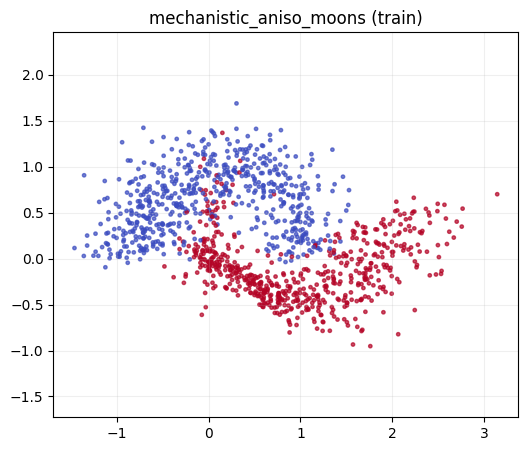

In [3]:
bundle = get_dataset('mechanistic_aniso_moons', cfg_base)
print('Train/val/test:', bundle.X_train.shape, bundle.X_val.shape, bundle.X_test.shape)
print('Meta:', bundle.meta)

plt.figure(figsize=(6, 5))
plt.scatter(bundle.X_train[:, 0], bundle.X_train[:, 1], c=bundle.y_train, s=6, cmap='coolwarm', alpha=0.7)
plt.title('mechanistic_aniso_moons (train)')
plt.axis('equal')
plt.grid(True, alpha=0.2)
plt.show()

### Train model + generate adversarial examples

In [4]:
model = get_model(
    "MLP",
    cfg_base,
    input_dim=int(bundle.X_train.shape[1]),
    output_dim=int(bundle.meta.get("num_classes", 2)),
)
trained = train(model, bundle, cfg_base)

clip = bundle.meta.get("clip", None)
X_adv_val = generate_adversarial(trained, bundle.X_val, bundle.y_val, cfg_base, clip=clip)
X_adv_test = generate_adversarial(trained, bundle.X_test, bundle.y_test, cfg_base, clip=clip)
print('Adv shapes:', X_adv_val.shape, X_adv_test.shape)

Epoch [10/30] Train Loss: 0.1804, Train Acc: 93.33%, Val Loss: 0.2839, Val Acc: 91.75%
Epoch [20/30] Train Loss: 0.1062, Train Acc: 95.75%, Val Loss: 0.3033, Val Acc: 96.25%
Early stopping at epoch 22
Adv shapes: (400, 2) (400, 2)


### Subsample val/test for PH scoring

In [5]:
# IMPORTANT: keep clean/adv *paired* by using the same indices.
# Successful-attack evaluation requires clean[i] and adv[i] to correspond to the same base sample.

rng = np.random.default_rng(SEED)

n_val = min(int(MAX_POINTS_FOR_SCORING), len(bundle.X_val))
idx_val = rng.choice(len(bundle.X_val), size=n_val, replace=False)

n_test = min(int(MAX_POINTS_FOR_SCORING), len(bundle.X_test))
idx_test = rng.choice(len(bundle.X_test), size=n_test, replace=False)

X_val_clean_used = np.asarray(bundle.X_val)[idx_val]
y_val_clean_used = np.asarray(bundle.y_val)[idx_val]
X_val_adv_used = np.asarray(X_adv_val)[idx_val]
y_val_adv_used = np.asarray(bundle.y_val)[idx_val]

X_test_clean_used = np.asarray(bundle.X_test)[idx_test]
y_test_clean_used = np.asarray(bundle.y_test)[idx_test]
X_test_adv_used = np.asarray(X_adv_test)[idx_test]
y_test_adv_used = np.asarray(bundle.y_test)[idx_test]

print('Val used:', X_val_clean_used.shape, X_val_adv_used.shape)
print('Test used:', X_test_clean_used.shape, X_test_adv_used.shape)

Val used: (300, 2) (300, 2)
Test used: (300, 2) (300, 2)


### Variant runner (V0–V3) + optional V4 contrastive gap

In [6]:
def run_variant(*, name: str, cfg: ExperimentConfig):
    t0 = time.time()
    scores_val_clean = compute_scores(X_val_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_val_adv = compute_scores(X_val_adv_used, trained, bundle=bundle, cfg=cfg)
    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    labels_val = np.concatenate([
        np.zeros(len(X_val_clean_used), dtype=int),
        np.ones(len(X_val_adv_used), dtype=int)
    ])

    scores_test_clean = compute_scores(X_test_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_test_adv = compute_scores(X_test_adv_used, trained, bundle=bundle, cfg=cfg)
    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    labels_test = np.concatenate([
        np.zeros(len(X_test_clean_used), dtype=int),
        np.ones(len(X_test_adv_used), dtype=int)
    ])

    use_pred_class = bool(
        cfg.detector.topo_class_conditional and cfg.detector.topo_class_scoring_mode in {
            'predicted_class',
            'contrastive_pred_gap',
            'contrastive',
            'pred_gap',
        }
    )
    if use_pred_class:
        y_pred_val_clean = get_model_predictions(trained, np.asarray(X_val_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_val_adv = get_model_predictions(trained, np.asarray(X_val_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_val_all = np.concatenate([y_pred_val_clean, y_pred_val_adv]).astype(int)
    else:
        y_pred_val_all = None

    det = fit_detector(
        scores_val_all,
        labels_val,
        cfg,
        y_true=np.concatenate([y_val_clean_used, y_val_adv_used]).astype(int),
        y_pred=y_pred_val_all,
    )

    if use_pred_class:
        y_pred_test_clean = get_model_predictions(trained, np.asarray(X_test_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_test_adv = get_model_predictions(trained, np.asarray(X_test_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_test_all = np.concatenate([y_pred_test_clean, y_pred_test_adv]).astype(int)
    else:
        y_pred_test_all = None

    # Evaluate detector scores (the evaluator expects y_true, y_scores)
    y_true_test_all = np.concatenate([y_test_clean_used, y_test_adv_used]).astype(int)
    try:
        # Class-conditional detector supports y_pred/y_true.
        y_score_test_all = det.score(scores_test_all, y_pred=y_pred_test_all, y_true=y_true_test_all)
    except TypeError:
        # Pooled detector ignores class context.
        y_score_test_all = det.score(scores_test_all)
    thr = getattr(det, 'threshold', None)
    metrics = evaluate_detector(y_true_test_all, np.asarray(y_score_test_all, dtype=float), threshold=thr)

    wall_s = time.time() - t0
    return {
        'name': name,
        'cfg': cfg,
        'detector': det,
        'scores_test_all': scores_test_all,
        'labels_test': labels_test,
        'metrics': metrics,
        'wall_s': wall_s,
        'scores_test_clean': scores_test_clean,
        'scores_test_adv': scores_test_adv,
        'y_pred_test_all': y_pred_test_all,
    }


# Define variants
#
# We add two mechanistic ablations:
# (1) INPUT-space topology features: do PH directly on X (2D), to verify that
#     whitening removes the injected anisotropy nuisance in the *known* space.
# (4) PCA confound ablation: compare topo_preprocess='pca' vs 'none' (and pca_dim=2)
#     to ensure results are not artifacts of local PCA.

# --- Feature-space variants (z = penultimate) ---
cfg_v0 = cfg_base  # pooled + global nbrs + pca(10) + no metric norm
cfg_v1 = replace(cfg_base, detector=replace(cfg_base.detector, topo_class_conditional=True, topo_class_scoring_mode='min_over_classes'))
cfg_v2 = replace(cfg_v1, graph=replace(cfg_base.graph, topo_neighbor_mode='class_pred'))
cfg_v3 = replace(cfg_v2, graph=replace(cfg_v2.graph, topo_metric_normalization='whiten'))
cfg_v4 = replace(cfg_v3, detector=replace(cfg_v3.detector, topo_class_scoring_mode='contrastive_pred_gap'))

# PCA ablation in feature space
cfg_f0_none = replace(cfg_v0, graph=replace(cfg_v0.graph, topo_preprocess='none'))
cfg_f0_pca2 = replace(cfg_v0, graph=replace(cfg_v0.graph, topo_preprocess='pca', topo_pca_dim=2))
cfg_f3_none = replace(cfg_v3, graph=replace(cfg_v3.graph, topo_preprocess='none'))

# --- Input-space variants (Z = X) ---
# For 2D inputs, PCA is unnecessary; we keep topo_preprocess='none'.
cfg_i0 = replace(cfg_base, graph=replace(cfg_base.graph, space='input', topo_preprocess='none', topo_metric_normalization='none'))
cfg_i1 = replace(cfg_base, graph=replace(cfg_base.graph, space='input', topo_preprocess='none', topo_metric_normalization='whiten'))

variants = [
    # Feature space (baseline ladder)
    ('V0_feat_pooled_global_pca10', cfg_v0),
    ('V1_feat_classcond_global_pca10', cfg_v1),
    ('V2_feat_classcond_classPredNbr_pca10', cfg_v2),
    ('V3_feat_classPredNbr_whiten_pca10', cfg_v3),
    ('V4_feat_contrastive_gap', cfg_v4),

    # (4) PCA confound ablations
    ('F0_feat_pooled_global_NONE', cfg_f0_none),
    ('F0_feat_pooled_global_pca2', cfg_f0_pca2),
    ('F3_feat_classPredNbr_whiten_NONE', cfg_f3_none),

    # (1) Input-space mechanistic sanity check
    ('I0_input_global_NONE', cfg_i0),
    ('I1_input_global_WHITEN', cfg_i1),
]

results = []
for name, cfg in variants:
    print('Running', name)
    r = run_variant(name=name, cfg=cfg)
    results.append(r)
    m = r['metrics']
    print('  roc_auc=', m.get('roc_auc'), 'pr_auc=', m.get('pr_auc'), 'fpr@95=', m.get('fpr_at_tpr95'), 'wall_s=', r['wall_s'])


Running V0_feat_pooled_global_pca10
  roc_auc= 0.5678196225071224 pr_auc= 0.5706390490521884 fpr@95= 0.9358974358974359 wall_s= 35.83138871192932
Running V1_feat_classcond_global_pca10
  roc_auc= 0.5476874109686609 pr_auc= 0.5411996666156587 fpr@95= 0.9423076923076923 wall_s= 35.234535932540894
Running V2_feat_classcond_classPredNbr_pca10
  roc_auc= 0.5066328347578348 pr_auc= 0.5060668052157926 fpr@95= 0.9294871794871795 wall_s= 35.50590705871582
Running V3_feat_classPredNbr_whiten_pca10
  roc_auc= 0.4224425747863248 pr_auc= 0.43484620508061544 fpr@95= 0.9871794871794872 wall_s= 36.34333419799805
Running V4_feat_contrastive_gap
  roc_auc= 0.6115896545584045 pr_auc= 0.5467151909208834 fpr@95= 0.967948717948718 wall_s= 36.54992914199829
Running F0_feat_pooled_global_NONE


/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.

  roc_auc= 0.5675970441595442 pr_auc= 0.5703315313514034 fpr@95= 0.9358974358974359 wall_s= 37.54000735282898
Running F0_feat_pooled_global_pca2
  roc_auc= 0.5054420405982906 pr_auc= 0.5179772052095343 fpr@95= 0.9807692307692307 wall_s= 37.87826585769653
Running F3_feat_classPredNbr_whiten_NONE


/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.9/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs/venv/lib/python3.

  roc_auc= 0.42777332621082625 pr_auc= 0.43675003721022876 fpr@95= 0.9871794871794872 wall_s= 37.73980498313904
Running I0_input_global_NONE
  roc_auc= 0.5526397792022792 pr_auc= 0.5529832184156899 fpr@95= 0.9262820512820513 wall_s= 26.8400239944458
Running I1_input_global_WHITEN
  roc_auc= 0.502437232905983 pr_auc= 0.48812457218285865 fpr@95= 0.9807692307692307 wall_s= 26.875675916671753


### ROC curves + score distributions

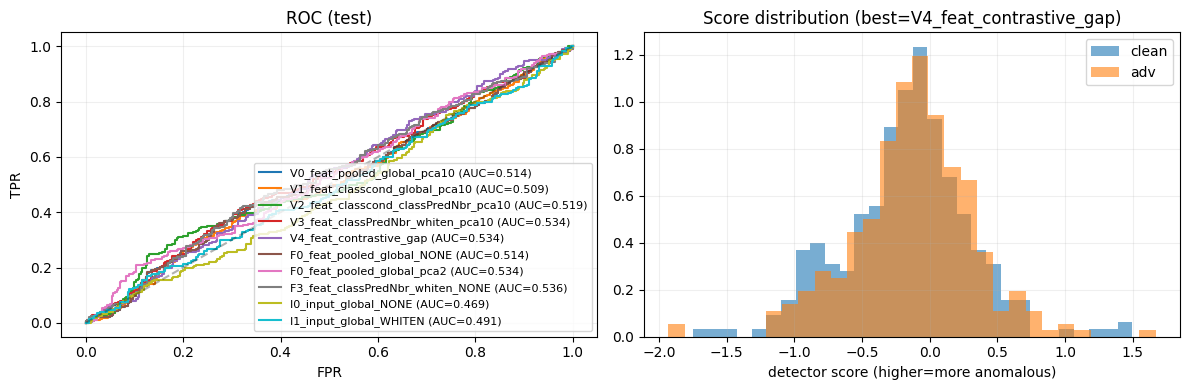

In [7]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
for r in results:
    y = np.asarray(r['labels_test']).astype(int)
    det = r['detector']
    try:
        s = np.asarray(det.score(r['scores_test_all'], y_pred=r.get('y_pred_test_all')))
    except TypeError:
        s = np.asarray(det.score(r['scores_test_all']))
    fpr, tpr, _ = roc_curve(y, s)
    ax.plot(fpr, tpr, label=f"{r['name']} (AUC={auc(fpr,tpr):.3f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC (test)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.2)

ax = axes[1]
best = max(results, key=lambda r: float(r['metrics'].get('roc_auc', 0.0)))
y = np.asarray(best['labels_test']).astype(int)
det = best['detector']
try:
    s = np.asarray(det.score(best['scores_test_all'], y_pred=best.get('y_pred_test_all')))
except TypeError:
    s = np.asarray(det.score(best['scores_test_all']))
ax.hist(s[y == 0], bins=30, alpha=0.6, density=True, label='clean')
ax.hist(s[y == 1], bins=30, alpha=0.6, density=True, label='adv')
ax.set_title(f"Score distribution (best={best['name']})")
ax.set_xlabel('detector score (higher=more anomalous)')
ax.legend()
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### Successful-only vs all-attacks stratification

We define "successful" adversarial as those that change the model's predicted class relative to the clean label.
This is *mechanistic* (not the primary detector metric), but should strengthen the effect if the hypothesis is boundary-related.

Successful attack rate: 0.07333333333333333


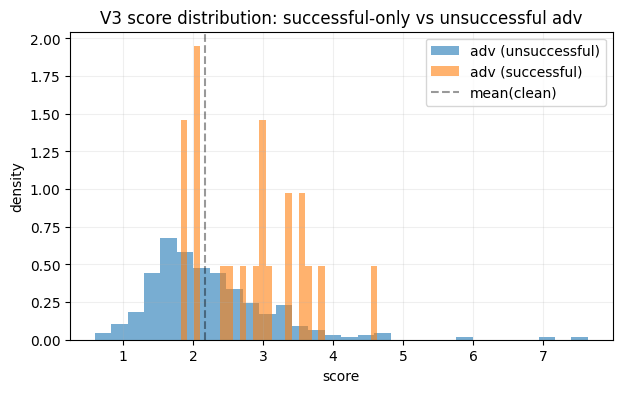

In [8]:
def _pred(x):
    return get_model_predictions(trained, np.asarray(x), device=str(cfg_base.device), return_probs=False).astype(int)

y_pred_clean = _pred(X_test_clean_used)
y_pred_adv = _pred(X_test_adv_used)
successful = (y_pred_adv != y_test_clean_used)
print('Successful attack rate:', float(successful.mean()))

# Pick the feature-space whitening variant (name changed after adding ablations)
target_name = 'V3_feat_classPredNbr_whiten_pca10'
r = next((rr for rr in results if rr['name'] == target_name), None)
if r is None:
    # Fallback: any variant containing both 'whiten' and 'feat'
    r = next(rr for rr in results if ('whiten' in rr['name'] and 'feat' in rr['name']))
det = r['detector']
try:
    scores_adv = det.score(r['scores_test_adv'], y_pred=y_pred_adv)
    scores_clean = det.score(r['scores_test_clean'], y_pred=y_pred_clean)
except TypeError:
    # Fallback if detector is pooled.
    scores_adv = det.score(r['scores_test_adv'])
    scores_clean = det.score(r['scores_test_clean'])

plt.figure(figsize=(7, 4))
plt.hist(scores_adv[~successful], bins=30, alpha=0.6, density=True, label='adv (unsuccessful)')
plt.hist(scores_adv[successful], bins=30, alpha=0.6, density=True, label='adv (successful)')
plt.axvline(np.mean(scores_clean), color='k', linestyle='--', alpha=0.4, label='mean(clean)')
plt.title('V3 score distribution: successful-only vs unsuccessful adv')
plt.xlabel('score')
plt.ylabel('density')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [9]:
# --- Successful-only evaluation across variants ---
# Define success as: clean correct AND adv incorrect (wrt y_true).
mask = attack_success_mask(
    trained,
    X_test_clean_used,
    X_test_adv_used,
    y_test_clean_used,
    device=str(cfg_base.device),
)
print('Successful (paired) count:', int(mask.sum()), '/', len(mask))

# Precompute predicted labels for class-conditional scoring (paired subsets)
y_pred_clean = get_model_predictions(trained, X_test_clean_used, device=str(cfg_base.device), return_probs=False).astype(int)
y_pred_adv = get_model_predictions(trained, X_test_adv_used, device=str(cfg_base.device), return_probs=False).astype(int)


def _mask_scores(scores_dict, m):
    return {k: np.asarray(v)[m] for k, v in scores_dict.items()}


def eval_success_only(r):
    det = r['detector']
    s_clean_dict = _mask_scores(r['scores_test_clean'], mask)
    s_adv_dict = _mask_scores(r['scores_test_adv'], mask)

    # scores (higher = more anomalous)
    try:
        s_clean = det.score(s_clean_dict, y_pred=y_pred_clean[mask], y_true=y_test_clean_used[mask])
        s_adv = det.score(s_adv_dict, y_pred=y_pred_adv[mask], y_true=y_test_clean_used[mask])
    except TypeError:
        s_clean = det.score(s_clean_dict)
        s_adv = det.score(s_adv_dict)

    y_true = np.concatenate([np.zeros(len(s_clean), dtype=int), np.ones(len(s_adv), dtype=int)])
    y_score = np.concatenate([np.asarray(s_clean, dtype=float), np.asarray(s_adv, dtype=float)])
    thr = getattr(det, 'threshold', None)
    return evaluate_detector(y_true, y_score, threshold=thr)


success_metrics = []
for r in results:
    m = eval_success_only(r)
    success_metrics.append((r['name'], float(m['roc_auc']), float(m['pr_auc']), float(m['fpr_at_tpr95'])))

# Print sorted by AUROC
success_metrics_sorted = sorted(success_metrics, key=lambda x: x[1], reverse=True)
print('--- Successful-only metrics (sorted by AUROC) ---')
for name, ra, pa, fpr95 in success_metrics_sorted:
    print(f"{name:35s}  roc_auc={ra:.3f}  pr_auc={pa:.3f}  fpr@95={fpr95:.3f}")


Successful (paired) count: 7 / 300
--- Successful-only metrics (sorted by AUROC) ---
V4_feat_contrastive_gap              roc_auc=0.918  pr_auc=0.909  fpr@95=0.143
F0_feat_pooled_global_pca2           roc_auc=0.776  pr_auc=0.750  fpr@95=0.429
V2_feat_classcond_classPredNbr_pca10  roc_auc=0.694  pr_auc=0.759  fpr@95=0.857
V3_feat_classPredNbr_whiten_pca10    roc_auc=0.592  pr_auc=0.588  fpr@95=0.714
F3_feat_classPredNbr_whiten_NONE     roc_auc=0.592  pr_auc=0.588  fpr@95=0.714
I1_input_global_WHITEN               roc_auc=0.510  pr_auc=0.524  fpr@95=0.857
V0_feat_pooled_global_pca10          roc_auc=0.367  pr_auc=0.464  fpr@95=0.857
F0_feat_pooled_global_NONE           roc_auc=0.367  pr_auc=0.464  fpr@95=0.857
V1_feat_classcond_global_pca10       roc_auc=0.327  pr_auc=0.452  fpr@95=1.000
I0_input_global_NONE                 roc_auc=0.306  pr_auc=0.420  fpr@95=0.857


## Analysis (data-supported)

### Narrow hypothesis (tested here)
We evaluate a *conditional* hypothesis:

> In representation space \(z=\phi_\ell(x)\), adversarial samples are enriched among points with **class-conditional, metric-conditioned** local geometry (PH feature vectors) that is atypical for the predicted class.

Operationally, we compare detector variants that change:
- neighborhood semantics: global vs predicted-class restricted
- local metric conditioning: none vs whiten
- scoring: pooled typicality vs class-conditional vs contrastive predicted-class gap

### Setup recap (mechanistic)
- Dataset: `mechanistic_aniso_moons` (two moons base + **location-dependent anisotropic noise** + optional warp)
- Sizes: train/val/test = (1200,2) / (400,2) / (400,2)
- PH scoring uses subsampled paired sets: **300 clean + 300 adv** on val and test.
- Attack: FGSM (\(\epsilon = 0.05\))

### Definitions (for clarity)
- Detector score \(s(x)\): higher = more anomalous.
- \(\mathrm{FPR@95}\): false positive rate at the threshold where true positive rate \(\ge 0.95\).
- **Successful attack mask** used in the mechanistic evaluation:

\[
\text{success}(i)=\big(\hat y(x_i)=y_i\big)\;\wedge\;\big(\hat y(x_i^{adv})\neq y_i\big)
\]

This is the right pairing-aware definition (clean/adv share the same base sample index).

---

## A) Primary result: all-attacks evaluation (detector setting)
Across *all* adversarial examples, performance is weak and operating points are unusable:
- FPR@95 is \(\approx 0.93\)–\(0.99\) across variants.
- AUROC is only slightly above chance (\(\approx 0.50\)–\(0.61\)); whitening variants are worse.

Key numbers (test):
- `V0_feat_pooled_global_pca10`: AUROC 0.568, FPR@95 0.936
- `V2_feat_classcond_classPredNbr_pca10`: AUROC 0.507, FPR@95 0.929
- `V3_feat_classPredNbr_whiten_pca10`: AUROC 0.422, FPR@95 0.987
- `V4_feat_contrastive_gap`: AUROC 0.612, FPR@95 0.968

**Interpretation:** this run provides *negative evidence* for a strong claim that “class-aware neighborhoods + whitening reliably improves detection” in this setting. Whitening appears harmful here.

### PCA confound check (feature-space)
The PCA ablation indicates the whitening failure is not an artifact of PCA:
- `F0_feat_pooled_global_NONE` \(\approx\) `V0_feat_pooled_global_pca10` (similar AUROC, similar FPR@95)
- Whitening is bad with or without PCA:
  - `V3_feat_classPredNbr_whiten_pca10`: AUROC 0.422
  - `F3_feat_classPredNbr_whiten_NONE`: AUROC 0.428

So the degradation is tied to whitening itself (or the interaction with scoring/features), not to local PCA being on/off.

### Input-space mechanistic sanity check
We also computed topology directly in input space \(X\in\mathbb{R}^2\):
- `I0_input_global_NONE`: AUROC 0.553, FPR@95 0.926
- `I1_input_global_WHITEN`: AUROC 0.502, FPR@95 0.981

**Interpretation:** even in the known 2D space where anisotropy was injected, whitening did not improve detection under the current configuration.

---

## B) Mechanistic result: successful-only evaluation (paired)
Paired successful count is **7/300** (≈2.3%), i.e. very small. Still, it provides a useful mechanistic probe.

Successful-only metrics (sorted by AUROC) show:
- `V4_feat_contrastive_gap`: AUROC 0.918, AUPRC 0.909, FPR@95 0.143
- Most other variants are mediocre or poor on the same subset.

**Interpretation:** conditional on attacks that actually flip the decision, the **contrastive predicted-class gap** score becomes strongly discriminative. This supports the *decision–geometry inconsistency* aspect of the narrowed hypothesis *in a conditional/mechanistic sense*.

**However:** because \(n=7\) successful examples is tiny, these successful-only numbers have high variance and cannot yet be treated as robust evidence. They are best reported as “suggestive / mechanistic”.

---

## C) What this means for the hypothesis
- This experiment does **not** refute the narrowed hypothesis globally.
- It *does* show that, for this dataset/attack strength, the hypothesis ingredients (especially whitening) do **not** yield a strong detector under all-attacks evaluation.
- The successful-only result suggests the mechanism may activate mainly when the attack actually crosses the boundary.

A careful paper-style statement would be:
> “We do not observe reliable improvements from metric conditioning (whitening) on this mechanistic anisotropic-moons setting under our current threat model. However, on the small subset of paired successful attacks, a contrastive class-conditional score shows strong separation, consistent with a boundary-linked inconsistency mechanism.”

---

## D) Recommended next steps (to strengthen mechanistic conclusions)
1) Increase successful-attack rate (e.g., stronger \(\epsilon\) or PGD) so successful-only has meaningful sample size.
2) Verify PH input/featureization is well-conditioned (ripser warnings about shape can indicate degenerate neighborhoods).
3) Re-run input-space `NONE` vs `WHITEN` with stronger anisotropy parameters to ensure the nuisance is actually present and measurable.


### PCA of penultimate features (clean vs adv)

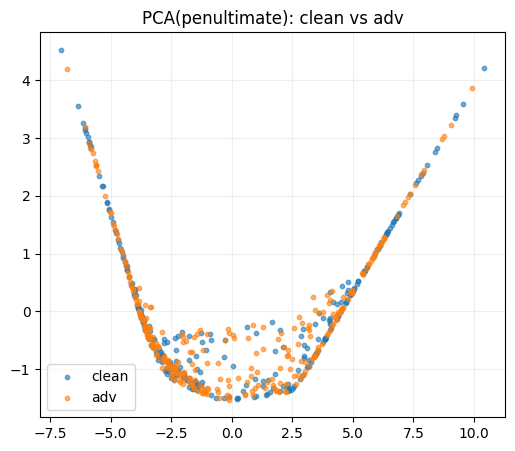

In [10]:
Z_train = extract_features_batch(trained, bundle.X_train, layer=str(cfg_base.graph.feature_layer), device=str(cfg_base.device))
Z_test_all = extract_features_batch(trained, np.concatenate([X_test_clean_used, X_test_adv_used], axis=0), layer=str(cfg_base.graph.feature_layer), device=str(cfg_base.device))
y_type = np.concatenate([np.zeros(len(X_test_clean_used), dtype=int), np.ones(len(X_test_adv_used), dtype=int)])

pca = PCA(n_components=2, random_state=SEED)
pca.fit(Z_train)
Z2 = pca.transform(Z_test_all)

plt.figure(figsize=(6, 5))
plt.scatter(Z2[y_type == 0, 0], Z2[y_type == 0, 1], s=10, alpha=0.6, label='clean')
plt.scatter(Z2[y_type == 1, 0], Z2[y_type == 1, 1], s=10, alpha=0.6, label='adv')
plt.title('PCA(penultimate): clean vs adv')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

### Score vs margin (decision proximity)

We compute the classification margin as (top1 logit - top2 logit).

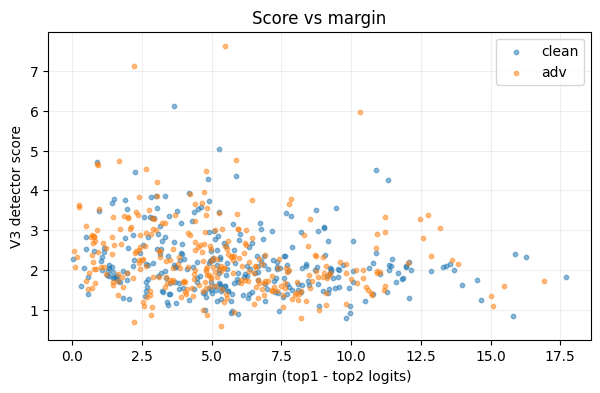

In [11]:
X_all = np.concatenate([X_test_clean_used, X_test_adv_used], axis=0)
y_type = np.concatenate([np.zeros(len(X_test_clean_used), dtype=int), np.ones(len(X_test_adv_used), dtype=int)])
logits = get_model_logits(trained, X_all, device=str(cfg_base.device))
top2 = np.sort(logits, axis=1)[:, -2:]
margin = top2[:, 1] - top2[:, 0]

target_name = 'V3_feat_classPredNbr_whiten_pca10'
r = next((rr for rr in results if rr['name'] == target_name), None)
if r is None:
    r = next(rr for rr in results if ('whiten' in rr['name'] and 'feat' in rr['name']))

det = r['detector']
try:
    scores = det.score(r['scores_test_all'], y_pred=r.get('y_pred_test_all'))
except TypeError:
    scores = det.score(r['scores_test_all'])

plt.figure(figsize=(7, 4))
plt.scatter(margin[y_type == 0], scores[y_type == 0], s=10, alpha=0.5, label='clean')
plt.scatter(margin[y_type == 1], scores[y_type == 1], s=10, alpha=0.5, label='adv')
plt.xlabel('margin (top1 - top2 logits)')
plt.ylabel('V3 detector score')
plt.title('Score vs margin')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()